In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg


Gathering Financial Data


In [33]:

ticker = '^DJA'
start = '2014-01-01'
end = '2024-04-01'
prices = yf.download(ticker, start, end, interval='1wk')['Close']

r0 = int(len(prices) * 0.01)



[*********************100%%**********************]  1 of 1 completed


Check Stationarity Function

In [34]:
def check_stationarity(ts):
    # Conduct the Augmented Dickey-Fuller test
    dftest = adfuller(ts, autolag='AIC')  # Using AIC to choose the best lag
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']  # Retrieving the critical value for 5% significance
    
    # Print results
    print(f'ADF Statistic: {adf}')
    print(f'p-value: {pvalue}')
    print(f'Critical Values at 5%: {critical_value}')
    
    # Evaluate stationarity based on the p-value and the ADF statistic
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')


Plotting Prices

ADF Statistic: -0.6907791064023708
p-value: 0.8491235216446215
Critical Values at 5%: -2.8669778698997543
The series is NOT stationary


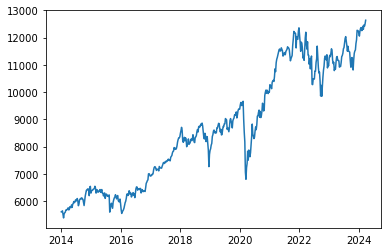

In [35]:
plt.plot(prices)
check_stationarity(prices)

Plotting Returns

ADF Statistic: -21.610228537112903
p-value: 0.0
Critical Values at 5%: -2.8669778698997543
The series is stationary


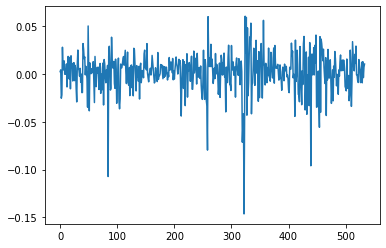

In [36]:
log_prices = np.array(np.log(prices))
delta_log_prices = log_prices[1:] - log_prices[:-1]
plt.plot(delta_log_prices)
check_stationarity(delta_log_prices)

Price Decomposition 


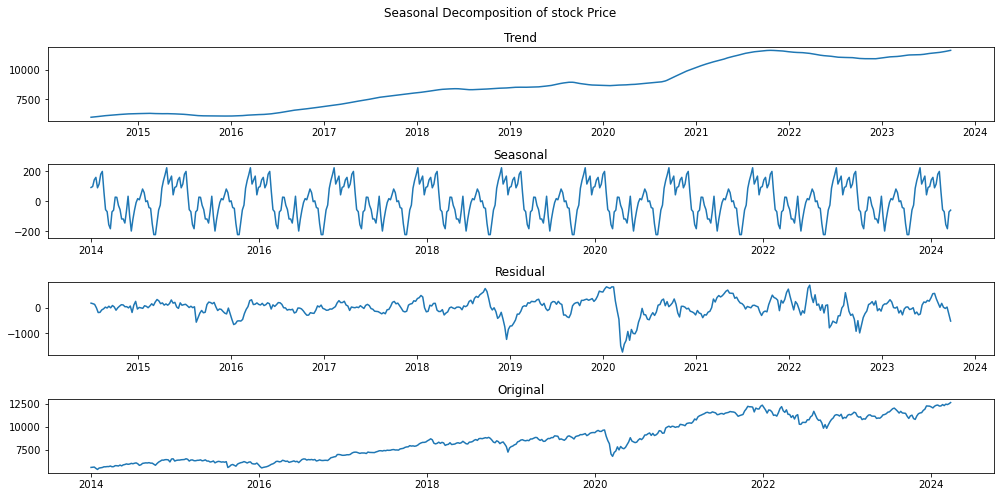

In [37]:
decompositionp = seasonal_decompose(prices, model = "additice", period = 52)

plt.figure(figsize=(14, 7))
plt.suptitle(f'Seasonal Decomposition of stock Price')
    
# Trend component
plt.subplot(411)
plt.plot(decompositionp.trend)
plt.title('Trend')
    
# Seasonal component
plt.subplot(412)
plt.plot(decompositionp.seasonal)
plt.title('Seasonal')
    
# Residual component
plt.subplot(413)
plt.plot(decompositionp.resid)
plt.title('Residual')
    
    # Original Data
plt.subplot(414)
plt.plot(prices)
plt.title('Original')

    
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top spacing to accommodate the suptitle
plt.show()

Percent Change Decomposition 

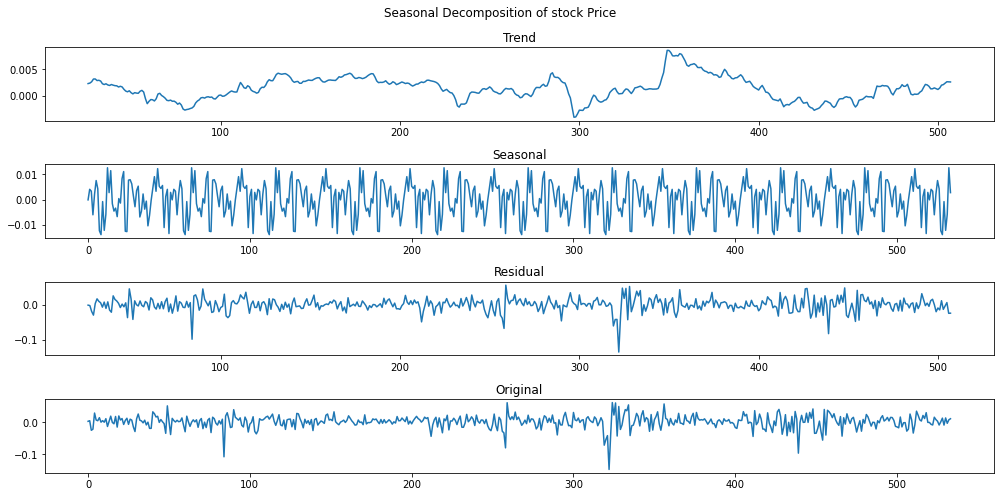

In [38]:
decompositionlog = seasonal_decompose(delta_log_prices, model='additive', period=52)
plt.figure(figsize=(14, 7))
plt.suptitle(f'Seasonal Decomposition of stock Price')
    
# Trend component
plt.subplot(411)
plt.plot(decompositionlog.trend)
plt.title('Trend')
    
# Seasonal component
plt.subplot(412)
plt.plot(decompositionlog.seasonal)
plt.title('Seasonal')
    
# Residual component
plt.subplot(413)
plt.plot(decompositionlog.resid)
plt.title('Residual')
    
    # Original Data
plt.subplot(414)
plt.plot(delta_log_prices)
plt.title('Original')
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust top spacing to accommodate the suptitle
plt.show()

ACF and PACF 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


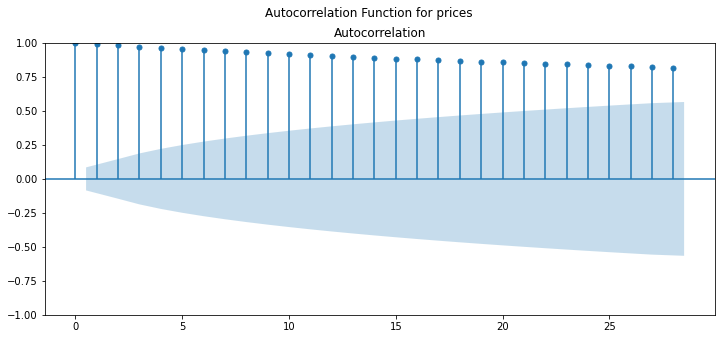

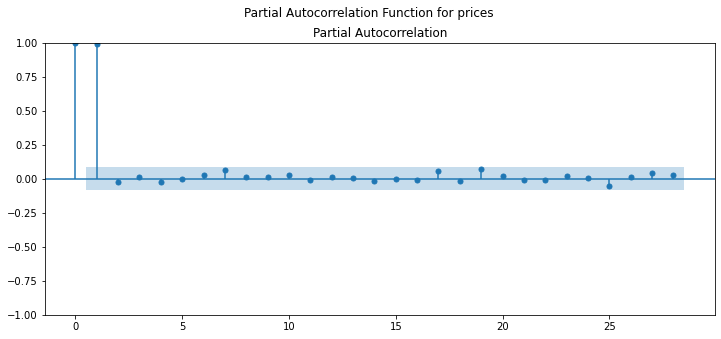

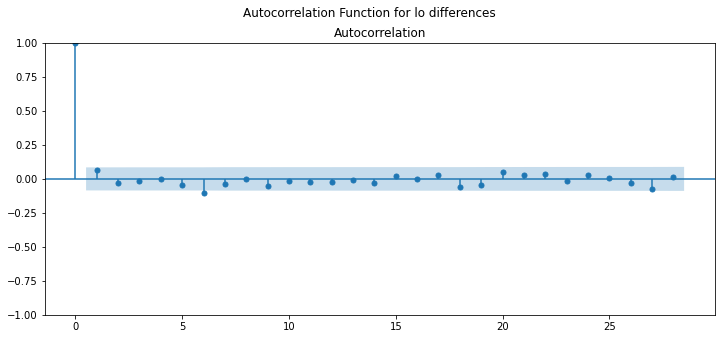

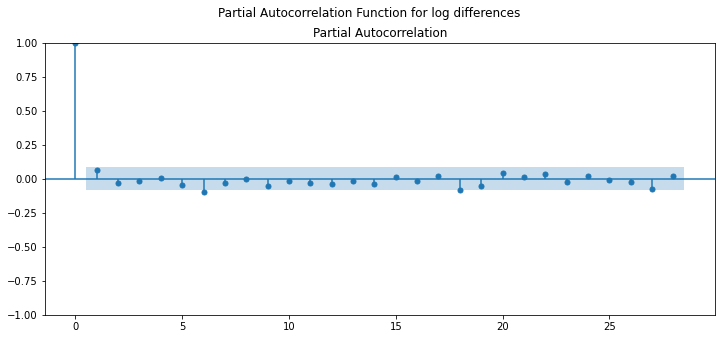

In [39]:
plt.figure(figsize=(12, 5))
plt.suptitle(f'Autocorrelation Function for prices')
plot_acf(prices, ax=plt.gca())
    
# Plot PACF
plt.figure(figsize=(12, 5))
plt.suptitle(f'Partial Autocorrelation Function for prices')
plot_pacf(prices, ax=plt.gca())

plt.figure(figsize=(12, 5))
plt.suptitle(f'Autocorrelation Function for lo differences')
plot_acf(delta_log_prices, ax=plt.gca())
    
# Plot PACF
plt.figure(figsize=(12, 5))
plt.suptitle(f'Partial Autocorrelation Function for log differences')
plot_pacf(delta_log_prices, ax=plt.gca())

plt.show()

In [40]:
def estimate_lag_effect(ts, lags):
    """
    Estimates the effect of lagged values on the current value of a time series.
    
    Parameters:
    - ts (pandas.Series or numpy.ndarray): The time series data.
    - lags (int): The number of lagged terms to include in the model.
    
    Returns:
    - result (RegressionResults): The regression results object from statsmodels.
    """
    # Convert numpy.ndarray to pandas.Series if necessary
    if isinstance(ts, np.ndarray):
        ts = pd.Series(ts)
    
    # Prepare the DataFrame to include lags
    df = pd.DataFrame({'y': ts})
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = ts.shift(lag)

    # Drop rows with NaN values which are the result of lagging
    df.dropna(inplace=True)
    
    # Define the independent variables (lagged values) and the dependent variable
    X = df.iloc[:, 1:]  # all lag columns
    y = df['y']
    
    # Add a constant to the model (intercept)
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X)
    result = model.fit()
    
    return result

result = estimate_lag_effect(ts, lags=2)
print(result.summary())

residuals = result.resid


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.377
Date:                Mon, 15 Apr 2024   Prob (F-statistic):              0.253
Time:                        19:35:09   Log-Likelihood:                 1319.1
No. Observations:                 532   AIC:                            -2632.
Df Residuals:                     529   BIC:                            -2619.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.656      0.0

Plotting

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6622
Date:                Mon, 15 Apr 2024   Prob (F-statistic):              0.619
Time:                        19:35:09   Log-Likelihood:                 1314.7
No. Observations:                 530   AIC:                            -2619.
Df Residuals:                     525   BIC:                            -2598.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.762      0.0

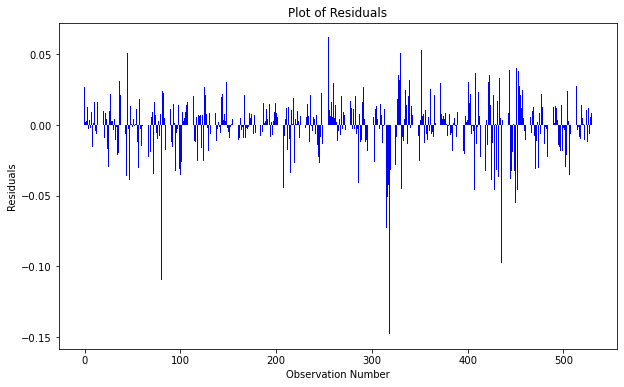

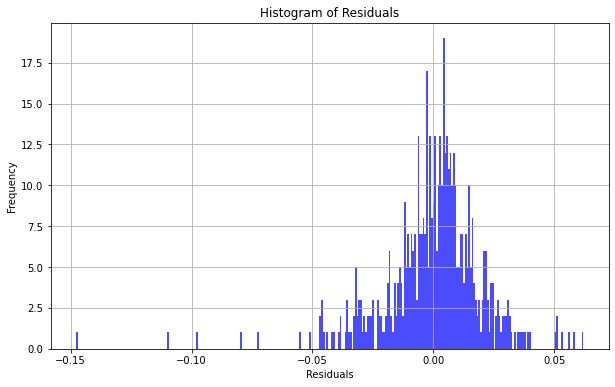

In [41]:

ts = delta_log_prices
result = estimate_lag_effect(ts, lags=4)
print(result.summary())

residuals = result.resid

# Plotting the residuals on a bar graph
plt.figure(figsize=(10, 6))
plt.bar(range(len(residuals)), residuals, color='blue')
plt.xlabel('Observation Number')
plt.ylabel('Residuals')
plt.title('Plot of Residuals')
plt.show()

# Plotting the residuals on a histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins= 300, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

In [42]:
adf_lags = 4
crit = 2.9

# Assuming log_prices and delta_log_prices are defined and r0 and adf_lags are set
n = len(delta_log_prices)
BSADF = np.zeros(n-r0)

for r2 in range(r0, n):
    ADFS = np.zeros(r2-r0+1)
    for r1 in range(0, r2-r0+1):
        X0 = log_prices[r1:r2+1]
        X = np.zeros((len(X0), adf_lags+1))
        X[:, 0] = X0
        for j in range(1, adf_lags+1):
            X[j:, j] = delta_log_prices[r1:r2+1-j]

        Y = delta_log_prices[r1:r2+1]
        reg = sm.OLS(Y, sm.add_constant(X))
        res = reg.fit()
        ADFS[r1] = res.params[1] / res.bse[1]

    BSADF[r2-r0] = np.max(ADFS)

# BSADF now holds all the BSADF values calculated


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


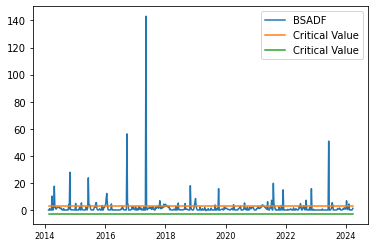

DatetimeIndex(['2014-03-26', '2014-04-23', '2014-10-15', '2014-10-29',
               '2015-01-07', '2015-03-18', '2015-06-10', '2015-06-17',
               '2015-07-01', '2015-09-09', '2015-09-16', '2015-11-25',
               '2015-12-30', '2016-01-06', '2016-01-13', '2016-01-20',
               '2016-01-27', '2016-03-16', '2016-09-21', '2016-09-28',
               '2016-10-05', '2017-05-10', '2017-10-25', '2017-11-01',
               '2017-12-13', '2017-12-27', '2018-01-03', '2018-01-10',
               '2018-01-17', '2018-06-06', '2018-08-29', '2018-10-31',
               '2018-12-19', '2018-12-26', '2019-01-02', '2019-08-28',
               '2019-10-09', '2020-04-08', '2020-08-19', '2021-03-24',
               '2021-03-31', '2021-04-07', '2021-05-26', '2021-07-14',
               '2021-08-04', '2021-08-11', '2021-08-18', '2021-11-10',
               '2021-12-01', '2022-06-29', '2022-08-03', '2022-08-10',
               '2022-09-07', '2022-11-09', '2023-06-07', '2023-07-19',
      

In [43]:
plt.rc('xtick', labelsize=8)  # Set x-tick label size
plt.plot(prices.index[r0+1:], BSADF, label='BSADF')  # Plot BSADF series
plt.plot(prices.index[r0+1:], np.ones(len(BSADF))*crit, label='Critical Value')  # Plot the critical value line
plt.plot(prices.index[r0+1:], np.ones(len(BSADF))*(-crit), label='Critical Value')  # Plot the critical value line


plt.legend()  # Add a legend to distinguish the plotted lines
plt.show()  # Display the plot

# Print the dates where BSADF exceeds the critical value
print(prices.index[r0+1:][BSADF > crit])

In [ ]:
# Define the LPPL model function
def lppl(t, A, B, tc, m, C, omega, phi):
    return A + B * np.power(tc - t, m) * (1 + C * np.cos(omega * np.log(tc - t) + phi))


In [ ]:
# Define the objective function to minimize (least squares)
def objective(params, t, y):
    A, B, tc, m, C, omega, phi = params
    return np.sum(np.square(lppl(t, A, B, tc, m, C, omega, phi) - y))

# Convert the index of prices to a time vector for LPPL modeling
t = np.arange(len(prices))

# Initial guess for parameters (replace with educated guess)
initial_guess = [0.5, -0.3, 500, 0.05, 0.05, 0.5, np.pi / 6]

# Minimize the objective function to estimate parameters
result = minimize(objective, initial_guess, args=(t, prices))

# Extract estimated parameters
estimated_params = result.x
print("Estimated Parameters:", estimated_params)

# Generate LPPL model values using estimated parameters
y_estimated = lppl(t, *estimated_params)

# Plotting (requires matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t, prices, label='Weekly Prices')
plt.plot(t, y_estimated, label='Estimated LPPL')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.title('LPPL Model Fitting for Bubble Detection')
plt.show()
